## Importing Libraries

In [124]:
import os
import pickle
import warnings
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np

In [125]:
!pip install numpy

## Defining segment length frame rate and bit rate 

In [126]:
segLen,frameRate,numMix = 3,50,128

## Function for Voice Activity Detection

In [127]:
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(wavData,hop_length=int(22050/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [128]:
wavFile="C:/Users/DELL/Downloads/crowd-talking-1.wav"

In [131]:
data,sr=librosa.load("C:/Users/DELL/Downloads/crowd-talking-1.wav")
sr

mfcc

array([[-4.1181955e+02,  8.7387077e+01, -6.5390305e+01, ...,
        -3.9538717e-01, -2.6964703e+00, -5.5891705e+00],
       [-3.3605038e+02,  7.8326324e+01, -7.5700638e+01, ...,
        -7.0446615e+00, -7.9310889e+00,  1.5583367e+00],
       [-3.0812039e+02,  7.0028900e+01, -8.9917870e+01, ...,
        -1.0084457e+01, -2.7408404e+00,  1.0844589e+01],
       ...,
       [-3.3165488e+02,  5.2859421e+00,  1.1015146e+01, ...,
         7.7436829e+00, -2.4195533e+00, -5.0434572e-01],
       [-3.6766699e+02,  5.5692978e+01, -1.6616787e+01, ...,
         2.9587483e+00,  1.3918991e+00, -7.1806327e-02],
       [-3.8779492e+02,  5.8773998e+01, -3.9395187e+01, ...,
         1.0819101e-01,  2.1270585e+00, -1.6475973e+00]], dtype=float32)

In [133]:
wavData,_ = librosa.load(wavFile,sr=22050)
%time vad=VoiceActivityDetection(wavData,frameRate)

CPU times: total: 46.9 ms
Wall time: 60.1 ms


C:\Users\DELL\AppData\Local\Temp\ipykernel_8736\3222100700.py:3: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.5501181e-04
 -4.7805901e-05  3.3788005e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ste = librosa.feature.rms(wavData,hop_length=int(22050/frameRate)).T


In [134]:
mfcc = librosa.feature.mfcc(wavData, sr=22050, n_mfcc=32,hop_length=int(22050/frameRate)).T
vad = np.reshape(vad,(len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad,:];

C:\Users\DELL\AppData\Local\Temp\ipykernel_8736\106175521.py:1: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.5501181e-04
 -4.7805901e-05  3.3788005e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(wavData, sr=22050, n_mfcc=32,hop_length=int(22050/frameRate)).T


## N_Component

In [135]:
n_components = np.arange(1, 25)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

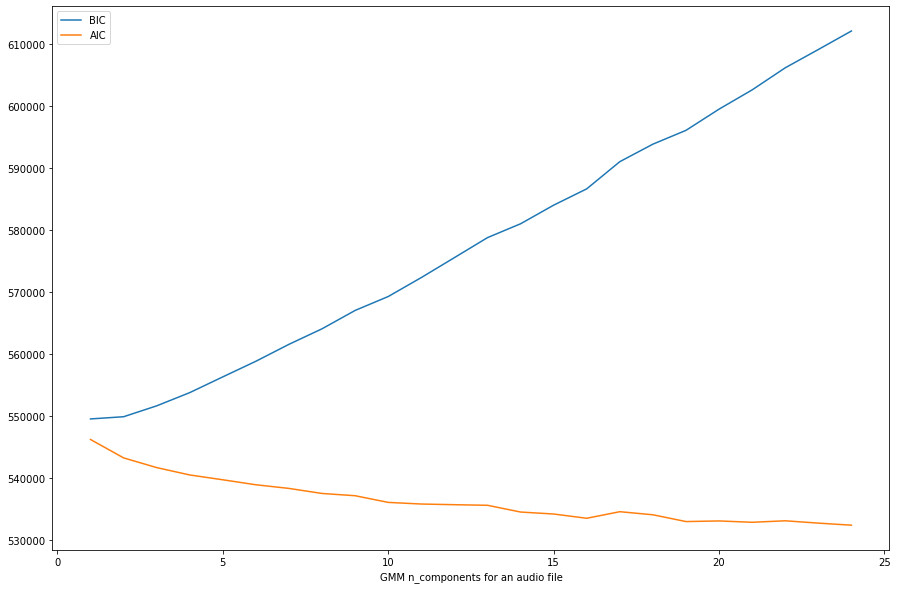

In [136]:
plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

22050

## GMM Training

In [141]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData,_ = librosa.load(wavFile,sr=22050)
    mfcc = librosa.feature.mfcc(wavData, sr=22050, n_mfcc=32,hop_length=int(22050/frameRate)).T
    vad = np.reshape(vad,(len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];
    print("Training GMM..")
    GMM = GaussianMixture(n_components=10,covariance_type='diag').fit(mfcc)
    var_floor = 1e-6
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")

    return np.asarray(segLikes)

In [142]:
clusterset = trainGMM(wavFile, frameRate, segLen, vad, numMix)

C:\Users\DELL\AppData\Local\Temp\ipykernel_8736\1570861840.py:3: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.5501181e-04
 -4.7805901e-05  3.3788005e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(wavData, sr=22050, n_mfcc=32,hop_length=int(22050/frameRate)).T


Training GMM..
Training Done


## Clustering Analysis

In [143]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterset)  
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
X_normalized = normalize(X_scaled)

In [144]:

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
clust=cluster.fit_predict(X_normalized)


## Convert Segment to Frame

In [145]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

In [146]:
frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])


## Adding Speaker Labels

In [147]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
            
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal
    

In [148]:
pass1hyp = -1*np.ones(len(vad))
pass1hyp[vad] = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, wavFile)


In [149]:
spkdf["TimeSeconds"]=spkdf.EndTime-spkdf.StartTime

In [150]:
spkdf

,Audio,SpeakerLabel,StartTime,EndTime,TimeSeconds
0,crowd-talking-1.wav,Speaker 0,0.46,29.16,28.70
1,crowd-talking-1.wav,Speaker 1,29.16,36.88,7.72
2,crowd-talking-1.wav,Speaker 0,36.88,49.24,12.36
3,crowd-talking-1.wav,Speaker 1,49.24,57.08,7.84
